In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jkuna\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import requests
from textblob import TextBlob



finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['NFLX']


news_tables = {}


for ticker in tickers:
        url = finviz_url + ticker
        req = Request(url=url, headers={'User-Agent': 'my-app'})
        response = urlopen(req)
        html = BeautifulSoup(response, features='html')
        news_table = html.find(id='news-table')
        news_tables[ticker] = news_table
        break


parsed_data = []

for ticker, news_table in news_tables.items():
    if news_table:
        for row in news_table.findAll('tr'):
            title = row.a.text.strip()  
            date_cell = row.td.text.strip()
            if ' ' in date_cell:  
                date_data = date_cell.split(' ')
                Date = date_data[0]
                time = date_data[1]
            else:
                Date = date_cell
                time = ''

            parsed_data.append([ticker, title])


df = pd.DataFrame(parsed_data, columns=['ticker', 'title'])
vader = SentimentIntensityAnalyzer()


    
f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)
df.rename(columns={'date': 'Date'}, inplace=True)
if 'time' in df.columns:
    df = df.drop(columns=['time'])
    
print(df)

   ticker                                              title  compound
0    NFLX  Judgement Day for Roaring Kitty? 3 Meme Stocks...    0.0000
1    NFLX  Netflix to open retail centers in Texas and Pe...    0.0000
2    NFLX  Is Netflix Inc (NASDAQ:NFLX) the Best Underval...    0.6369
3    NFLX  Investors Heavily Search Netflix, Inc. (NFLX):...    0.0000
4    NFLX  Analyst reboots Trade Desk stock price target ...    0.0000
..    ...                                                ...       ...
95   NFLX  3 Up-and-Coming Media Stocks Set to Shake Up t...   -0.1779
96   NFLX               Is It Too Late to Buy Netflix Stock?    0.0000
97   NFLX  Google And Eli Lilly Have Things In Common Bes...    0.4215
98   NFLX  Netflix, Novo Nordisk And These IPOs Fuel Smor...    0.0000
99   NFLX  Analysts Say These 3 Stocks Are the Biggest Wi...    0.4767

[100 rows x 3 columns]


In [28]:
df.loc[0, 'x'] = 1

aa=0.0
posi_trade=0.0
neg_trade=0.0
for i in range(1, len(df)):
    df.loc[i, 'x'] = df.loc[i - 1, 'x'] * (df.loc[i, 'compound'] + 1)
    aa= aa+ df.loc[i, 'compound']/10
    if df.loc[i, 'x']-df.loc[i - 1, 'x']>0:
        posi_trade=posi_trade+1
    elif df.loc[i, 'x']-df.loc[i - 1, 'x']<0:
        neg_trade=neg_trade+1


mean= aa/len(df)
print(mean)

def get_stock_data(ticker, start_date, end_date):
    tickerData = yf.Ticker(ticker)
    return tickerData.history(period='1d', start=start_date, end=end_date)
    
stock_data1 = get_stock_data('NFLX', '2000-01-01', '2024-12-31')
stock_data1 = stock_data1.reset_index(drop=False)
stock_data1['Date'] = stock_data1['Date'].dt.strftime('%b-%d-%y')
print(stock_data1)

0.014445500000000002
           Date        Open        High         Low       Close     Volume  \
0     May-23-02    1.156429    1.242857    1.145714    1.196429  104790000   
1     May-24-02    1.214286    1.225000    1.197143    1.210000   11104800   
2     May-28-02    1.213571    1.232143    1.157143    1.157143    6609400   
3     May-29-02    1.164286    1.164286    1.085714    1.103571    6757800   
4     May-30-02    1.107857    1.107857    1.071429    1.071429   10154200   
...         ...         ...         ...         ...         ...        ...   
5551  Jun-12-24  652.210022  655.780029  643.109985  650.059998    2094400   
5552  Jun-13-24  644.000000  655.250000  642.349976  653.260010    1863600   
5553  Jun-14-24  655.049988  675.580017  652.640015  669.380005    4447100   
5554  Jun-17-24  669.109985  682.710022  665.109985  675.830017    3631200   
5555  Jun-18-24  675.630005  687.059998  674.640015  685.669983    2943800   

      Dividends  Stock Splits  
0         

In [5]:
import math

ok = 0
sum = 0.0
sum_squared_diff = 0.0  

for index, row in df.iterrows():
    compound_score = row['compound']
    ok += 1
    sum += compound_score/10.0

mean = sum / ok

for index, row in df.iterrows():
    compound_score = row['compound']
    sum_squared_diff += (compound_score - mean) ** 2



std_dev = math.sqrt(sum_squared_diff / ok)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")

import numpy as np


risk_free_rate = 0.0

sharpe_ratio = (mean - risk_free_rate) / std_dev * np.sqrt(252)

def buy_sell_hold(compound_value):
    if compound_value > 0.5:
        return 'Buy'
    elif compound_value < 0:
        return 'Sell'
    else:
        return 'Hold'


df['action'] = df['compound'].apply(buy_sell_hold)

buy=0
sell=0
hold=0

for index, row in df.iterrows():
    compound_score = row['compound']
    if compound_score > 0.1:
        sell += 1
    elif compound_score < -0.1:
        buy += 1
    else:
        hold += 1

print(df)

max= df['compound'].max()
min=df['compound'].min()
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"max: {max}")
print(f"min: {min}")
print(f"drodown: {max-min}")
print(f"buy: {buy}")
print(f"sell: {sell}")
print(f"hold: {hold}")
print("positive trades",posi_trade)
print("negative trades",neg_trade)
winratio =posi_trade/neg_trade
print("win ratio ",winratio)
print("return % most efficient way for past 100 days=",sum,"%")

Mean: 0.014445500000000002
Standard Deviation: 0.3358425082762009
   ticker                                              title  compound  \
0    NFLX  Judgement Day for Roaring Kitty? 3 Meme Stocks...    0.0000   
1    NFLX  Netflix to open retail centers in Texas and Pe...    0.0000   
2    NFLX  Is Netflix Inc (NASDAQ:NFLX) the Best Underval...    0.6369   
3    NFLX  Investors Heavily Search Netflix, Inc. (NFLX):...    0.0000   
4    NFLX  Analyst reboots Trade Desk stock price target ...    0.0000   
..    ...                                                ...       ...   
95   NFLX  3 Up-and-Coming Media Stocks Set to Shake Up t...   -0.1779   
96   NFLX               Is It Too Late to Buy Netflix Stock?    0.0000   
97   NFLX  Google And Eli Lilly Have Things In Common Bes...    0.4215   
98   NFLX  Netflix, Novo Nordisk And These IPOs Fuel Smor...    0.0000   
99   NFLX  Analysts Say These 3 Stocks Are the Biggest Wi...    0.4767   

              x action  
0      1.000000   Ho

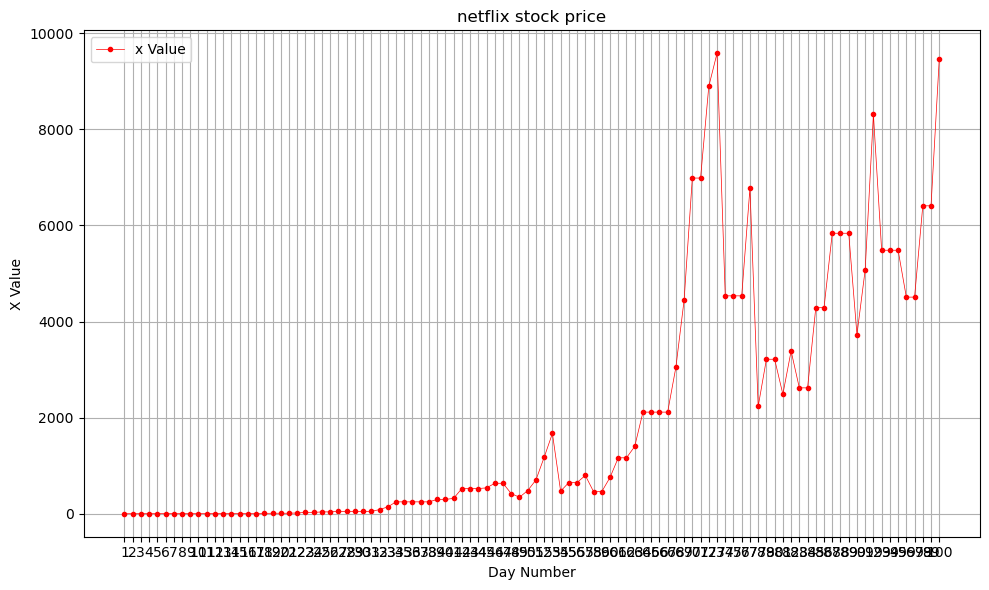

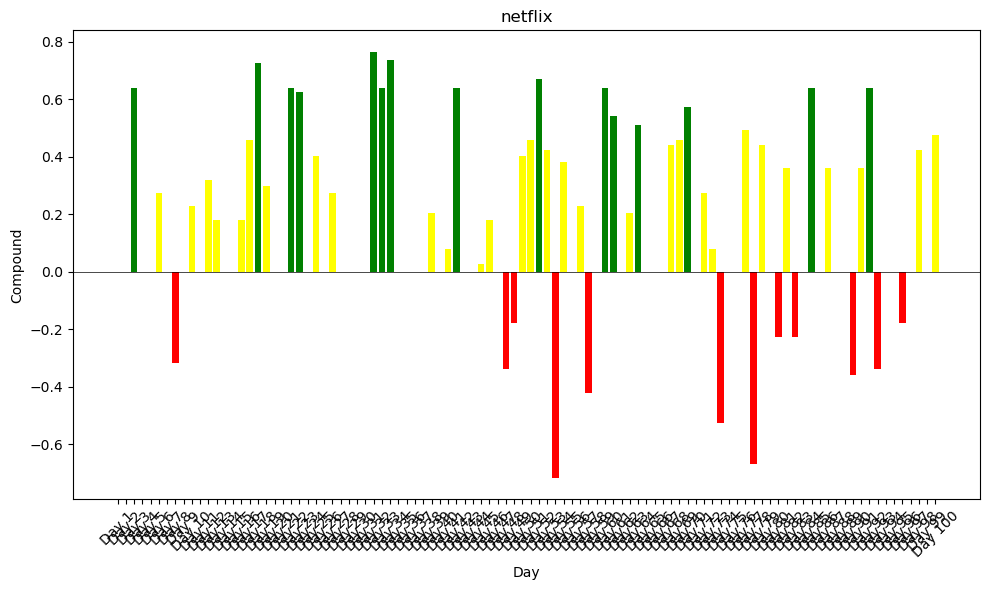

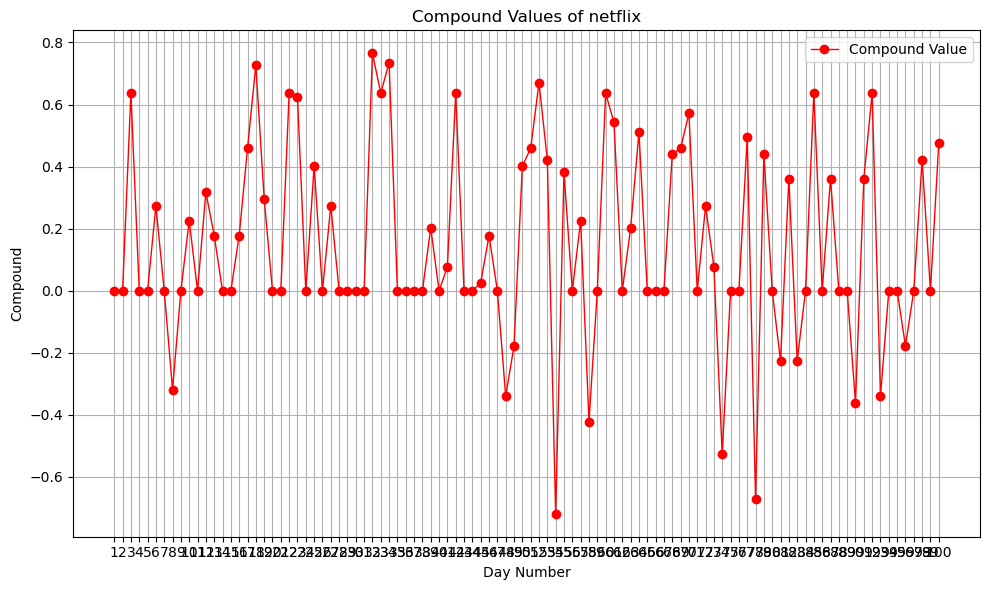

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.index + 1, df['x'], marker='.', linestyle='-', color='r', linewidth=0.5, label='x Value')

plt.title('netflix stock price')
plt.xlabel('Day Number')
plt.ylabel('X Value')
plt.xticks(df.index + 1)  
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

colors = []
for value in df['compound']:
    if value > 0.5:
        colors.append('green')
    elif value < -0:
        colors.append('red')
    else:
        colors.append('yellow')

plt.figure(figsize=(10, 6))
plt.bar(df.index + 1, df['compound'], color=colors, width=0.8)  

plt.title('netflix')
plt.xlabel('Day')
plt.ylabel('Compound')
plt.axhline(0, color='black', linewidth=0.5)  
plt.xticks(df.index + 1, [f'Day {i+1}' for i in df.index], rotation=45)  
plt.tight_layout()

plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df.index + 1, df['compound'], marker='o', linestyle='-', color='r', linewidth=1, label='Compound Value')

plt.title('Compound Values of netflix')
plt.xlabel('Day Number')
plt.ylabel('Compound')
plt.xticks(df.index + 1)  
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

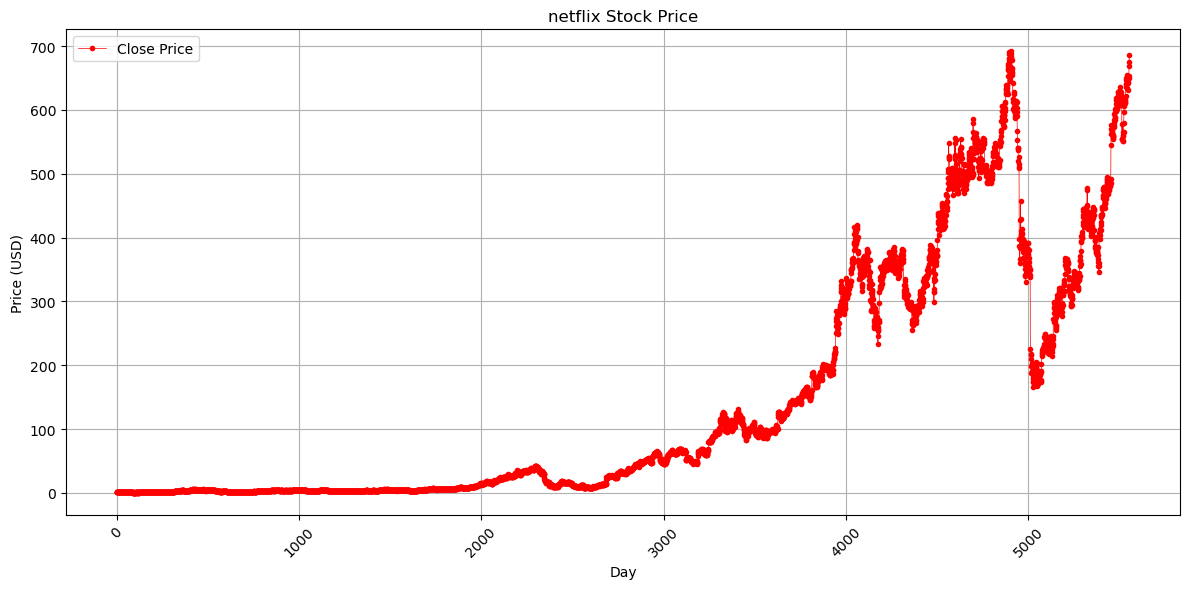

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data1.index, stock_data1['Close'], marker='.', linestyle='-', linewidth=0.5,color='r', label='Close Price')

plt.title('netflix Stock Price')
plt.xlabel('Day')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['DIS']

news_tables = {}

for ticker in tickers:
        url = finviz_url + ticker
        req = Request(url=url, headers={'User-Agent': 'my-app'})
        response = urlopen(req)
        html = BeautifulSoup(response, features='html')
        news_table = html.find(id='news-table')
        news_tables[ticker] = news_table
        break


parsed_data = []

for ticker, news_table in news_tables.items():
    if news_table:
        for row in news_table.findAll('tr'):
            title = row.a.text.strip()  

            date_cell = row.td.text.strip()
            if ' ' in date_cell:  
                date_data = date_cell.split(' ')
                Date = date_data[0]
                time = date_data[1]
            else:
                Date = date_cell
                time = ''

            parsed_data.append([ticker,  title])


df2 = pd.DataFrame(parsed_data, columns=['ticker',  'title'])
vader = SentimentIntensityAnalyzer()


    
f = lambda title: vader.polarity_scores(title)['compound']
df2['compound'] = df2['title'].apply(f)
df2.rename(columns={'date': 'Date'}, inplace=True)
if 'time' in df2.columns:
    df2 = df2.drop(columns=['time'])
    

df2.loc[0, 'x'] = 1

aa=0.0
posi_trade=0.0
neg_trade=0.0
for i in range(1, len(df2)):
    df2.loc[i, 'x'] = df2.loc[i - 1, 'x'] * (df2.loc[i, 'compound'] + 1)
    aa= aa+ df2.loc[i, 'compound']/10
    if df2.loc[i, 'x']-df2.loc[i - 1, 'x']>0:
        posi_trade=posi_trade+1
    elif df2.loc[i, 'x']-df2.loc[i - 1, 'x']<0:
        neg_trade=neg_trade+1


mean= aa/len(df2)


def get_stock_data(ticker, start_date, end_date):
    tickerData = yf.Ticker(ticker)
    return tickerData.history(period='1d', start=start_date, end=end_date)
    
stock_data2 = get_stock_data('DIS', '2000-01-01', '2024-12-31')
stock_data2 = stock_data2.reset_index(drop=False)

stock_data2['Date'] = stock_data2['Date'].dt.strftime('%b-%d-%y')



import math


ok = 0
sum = 0.0
sum_squared_diff = 0.0  


for index, row in df2.iterrows():
    compound_score = row['compound']
    ok += 1
    sum += compound_score/10.0

mean = sum / ok

for index, row in df2.iterrows():
    compound_score = row['compound']
    sum_squared_diff += (compound_score - mean) ** 2


std_dev = math.sqrt(sum_squared_diff / ok)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")

import numpy as np

risk_free_rate = 0.0
sharpe_ratio = (mean - risk_free_rate) / std_dev * np.sqrt(252)

def buy_sell_hold(compound_value):
    if compound_value > 0.5:
        return 'Buy'
    elif compound_value < 0:
        return 'Sell'
    else:
        return 'Hold'


df2['action'] = df2['compound'].apply(buy_sell_hold)

buy=0
sell=0
hold=0

for index, row in df2.iterrows():
    compound_score = row['compound']
    if compound_score > 0.1:
        sell += 1
    elif compound_score < -0.1:
        buy += 1
    else:
        hold += 1

print(df2)

max= df2['compound'].max()
min=df2['compound'].min()
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"max: {max}")
print(f"min: {min}")
print(f"drodown: {max-min}")
print(f"buy: {buy}")
print(f"sell: {sell}")
print(f"hold: {hold}")
print("positive trades",posi_trade)
print("negative trades",neg_trade)
winratio =posi_trade/neg_trade
print("win ratio ",winratio)
print("return % most efficient way for past 100 days=",sum,"%")

Mean: 0.0080256
Standard Deviation: 0.2977290260424068
   ticker                                              title  compound  \
0     DIS  These employees moved across the country for w...   -0.2732   
1     DIS  Guess How Many Parents Go Into Debt For A Disn...   -0.6124   
2     DIS  Disney told L.A. residents to move to Florida ...   -0.2732   
3     DIS  Is Netflix Inc (NASDAQ:NFLX) the Best Underval...    0.6369   
4     DIS                 Is Disney Animation Back on Track?    0.0000   
..    ...                                                ...       ...   
95    DIS  Dividend Duds: 3 Stocks to Dump Before They Dr...   -0.3818   
96    DIS  Here's Why Walt Disney Co (NYSE:DIS) is a Top ...    0.2023   
97    DIS  The Walt Disney Company's (DIS) Operating Inco...    0.0000   
98    DIS      Jim Cramer's 10 Stock Picks Heading Into June    0.0000   
99    DIS  3 Exceptional Growth Stocks to Buy Hand Over F...    0.7003   

            x action  
0    1.000000   Sell  
1    0.387

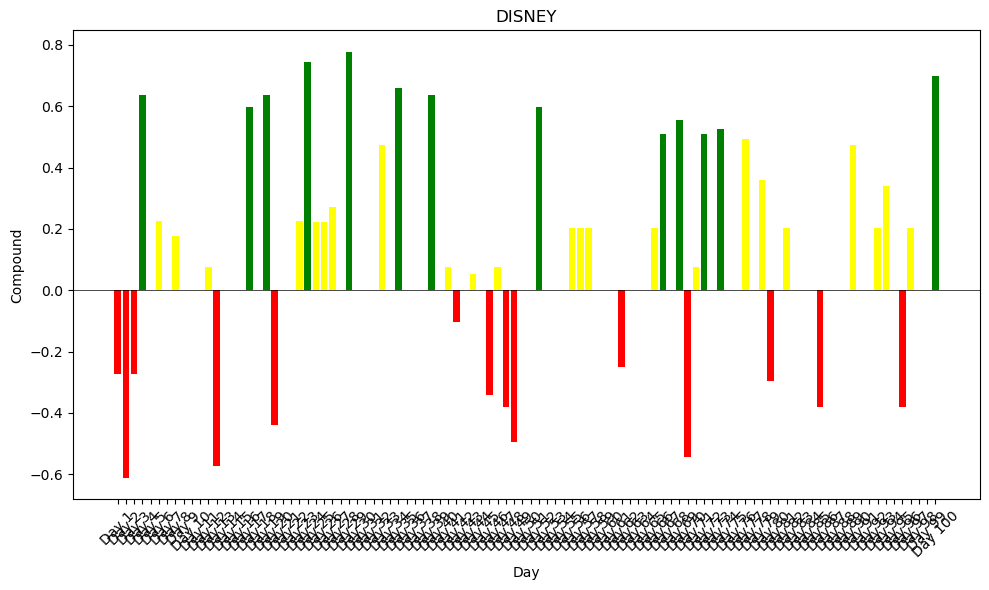

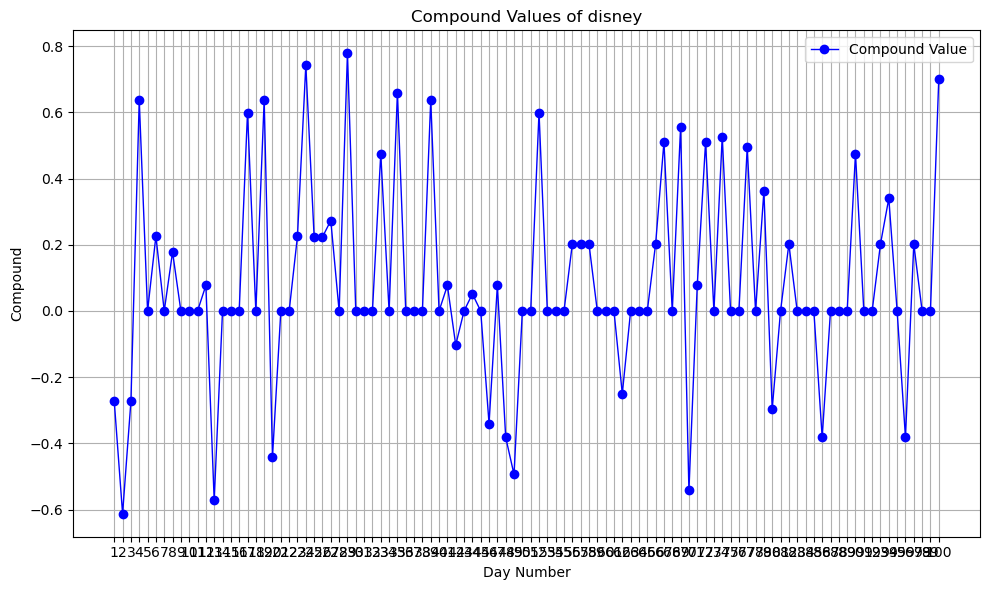

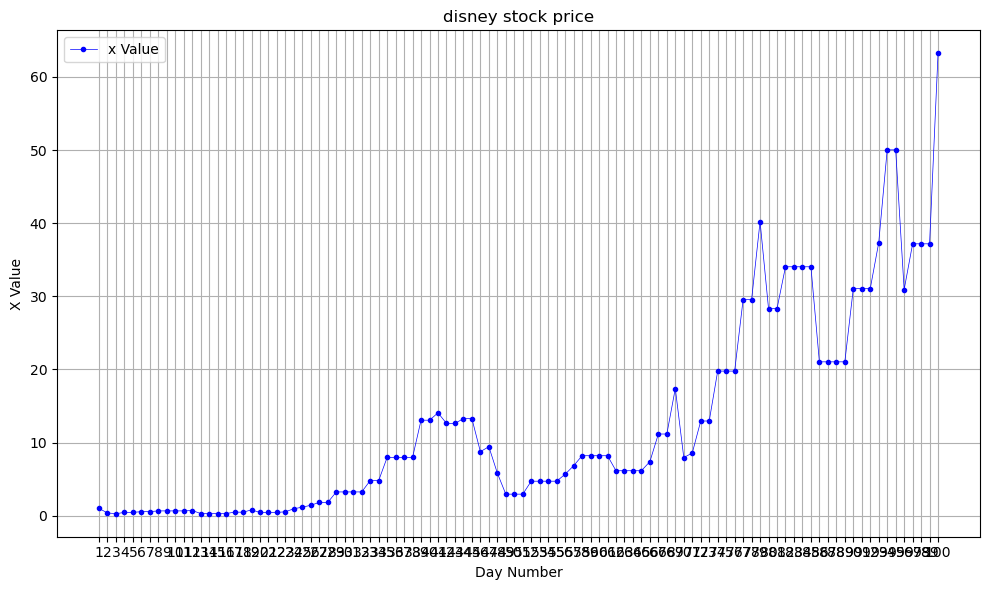

In [33]:
colors = []
for value in df2['compound']:
    if value > 0.5:
        colors.append('green')
    elif value < -0:
        colors.append('red')
    else:
        colors.append('yellow')

plt.figure(figsize=(10, 6))
plt.bar(df2.index + 1, df2['compound'], color=colors, width=0.8)  


plt.title('DISNEY')
plt.xlabel('Day')
plt.ylabel('Compound')
plt.axhline(0, color='black', linewidth=0.5)  
plt.xticks(df2.index + 1, [f'Day {i+1}' for i in df2.index], rotation=45)  
plt.tight_layout()

plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df2.index + 1, df2['compound'], marker='o', linestyle='-', color='b', linewidth=1, label='Compound Value')

plt.title('Compound Values of disney')
plt.xlabel('Day Number')
plt.ylabel('Compound')
plt.xticks(df2.index + 1)  
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df2.index + 1, df2['x'], marker='.', linestyle='-', color='b', linewidth=0.5, label='x Value')

plt.title('disney stock price')
plt.xlabel('Day Number')
plt.ylabel('X Value')
plt.xticks(df2.index + 1)  
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

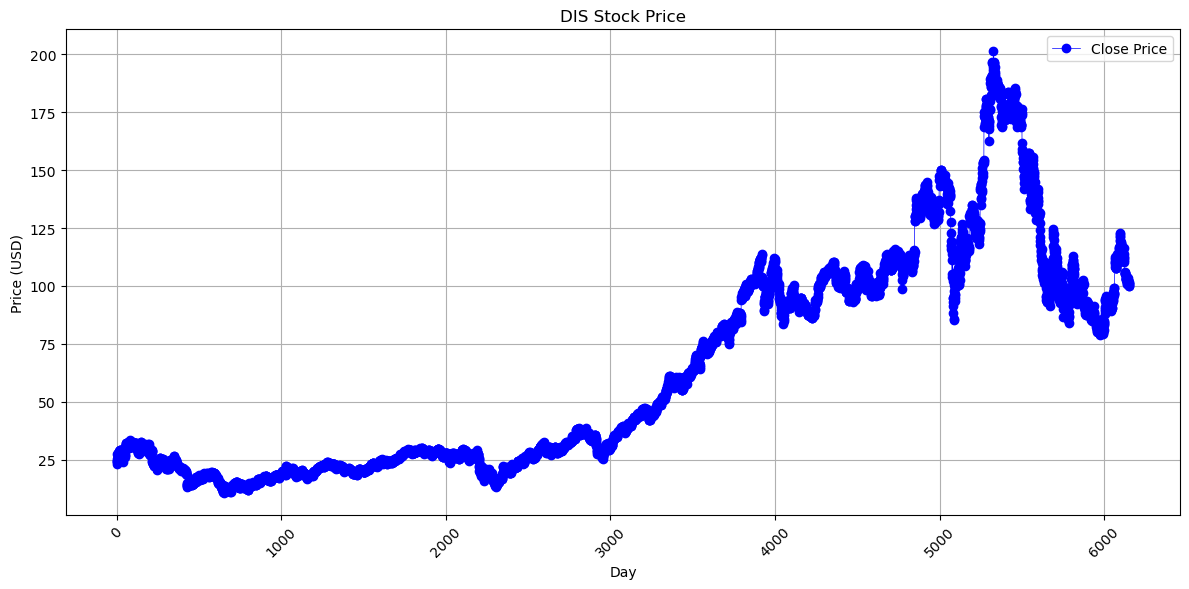

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data2.index, stock_data2['Close'], marker='o', linestyle='-', linewidth=0.5,color='b', label='Close Price')

plt.title(f'{ticker} Stock Price')
plt.xlabel('Day')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AMZN']


news_tables = {}


for ticker in tickers:
        url = finviz_url + ticker
        req = Request(url=url, headers={'User-Agent': 'my-app'})
        response = urlopen(req)
        html = BeautifulSoup(response, features='html')
        news_table = html.find(id='news-table')
        news_tables[ticker] = news_table
        break


parsed_data = []

for ticker, news_table in news_tables.items():
    if news_table:
        for row in news_table.findAll('tr'):
            title = row.a.text.strip()  

            
            date_cell = row.td.text.strip()
            if ' ' in date_cell: 
                date_data = date_cell.split(' ')
                Date = date_data[0]
                time = date_data[1]
            else:
                Date = date_cell
                time = ''

            parsed_data.append([ticker, title])


df3 = pd.DataFrame(parsed_data, columns=['ticker',  'title'])
vader = SentimentIntensityAnalyzer()


    
f = lambda title: vader.polarity_scores(title)['compound']
df3['compound'] = df3['title'].apply(f)
df3.rename(columns={'date': 'Date'}, inplace=True)
if 'time' in df3.columns:
    df3 = df3.drop(columns=['time'])
    


df3.loc[0, 'x'] = 1

aa=0.0
posi_trade=0.0
neg_trade=0.0
for i in range(1, len(df3)):
    df3.loc[i, 'x'] = df3.loc[i - 1, 'x'] * (df3.loc[i, 'compound']/10 + 1)
    aa= aa+ df3.loc[i, 'compound']/10
    if df3.loc[i, 'x']-df3.loc[i - 1, 'x']>0:
        posi_trade=posi_trade+1
    elif df3.loc[i, 'x']-df3.loc[i - 1, 'x']<0:
        neg_trade=neg_trade+1
mean= aa/len(df3)



def get_stock_data(ticker, start_date, end_date):
    tickerData = yf.Ticker(ticker)
    return tickerData.history(period='1d', start=start_date, end=end_date)
    
stock_data3 = get_stock_data('AMZN', '2000-01-01', '2024-12-31')
stock_data3 = stock_data3.reset_index(drop=False)


stock_data3['Date'] = stock_data3['Date'].dt.strftime('%b-%d-%y')



import math
ok = 0
sum = 0.0
sum_squared_diff = 0.0  


for index, row in df3.iterrows():
    compound_score = row['compound']
    ok += 1
    sum += compound_score/10.0

mean = sum / ok

for index, row in df3.iterrows():
    compound_score = row['compound']
    sum_squared_diff += (compound_score - mean) ** 2


std_dev = math.sqrt(sum_squared_diff / ok)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")

import numpy as np

risk_free_rate = 0.0

sharpe_ratio = (mean - risk_free_rate) / std_dev * np.sqrt(252)

def buy_sell_hold(compound_value):
    if compound_value > 0.5:
        return 'Buy'
    elif compound_value < 0:
        return 'Sell'
    else:
        return 'Hold'

df3['action'] = df3['compound'].apply(buy_sell_hold)

buy=0
sell=0
hold=0

for index, row in df3.iterrows():
    compound_score = row['compound']
    if compound_score > 0.1:
        sell += 1
    elif compound_score < -0.1:
        buy += 1
    else:
        hold += 1

print(df3)

max= df3['compound'].max()
min=df3['compound'].min()
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"max: {max}")
print(f"min: {min}")
print(f"drodown: {max-min}")
print(f"buy: {buy}")
print(f"sell: {sell}")
print(f"hold: {hold}")
print("positive trades",posi_trade)
print("negative trades",neg_trade)
winratio =posi_trade/neg_trade
print("win ratio ",winratio)
print("return % most efficient way for past 100 days=",sum,"%")

Mean: 0.025002999999999997
Standard Deviation: 0.35754119626834624
   ticker                                              title  compound  \
0    AMZN  Rag to Riches: 3 Autonomous Driving Stocks Tha...    0.7906   
1    AMZN  Shopifys gains with big retailers are setting ...    0.6369   
2    AMZN  3 Stocks You Don't Want to Be Caught Holding W...   -0.0572   
3    AMZN  Amazon (AMZN) Strengthens Blink Portfolio With...    0.5719   
4    AMZN  Why Amazon (AMZN) is a Top Growth Stock for th...    0.6249   
..    ...                                                ...       ...   
95   AMZN  Even If Stock-Split Stock Nvidia Retains Its C...    0.2960   
96   AMZN                 Is It Too Late to Buy Apple Stock?    0.0000   
97   AMZN     2 Soaring Stocks to Hold for the Next 20 Years    0.0000   
98   AMZN  Morningstar | A Weekly Summary of Stock Ideas ...    0.0000   
99   AMZN  2 Artificial Intelligence (AI) Stocks That Cou...    0.4767   

            x action  
0    1.000000    Buy 

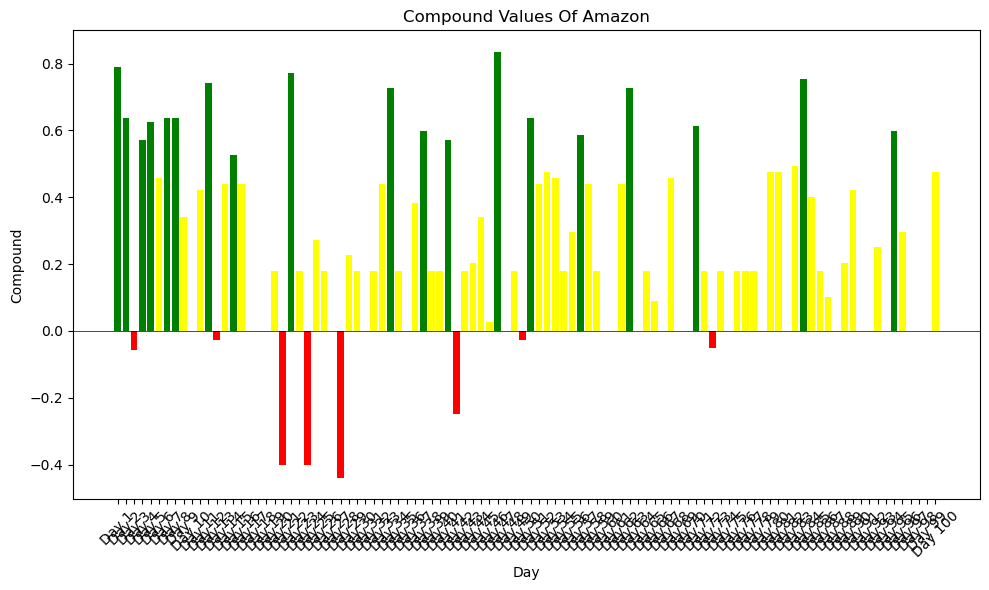

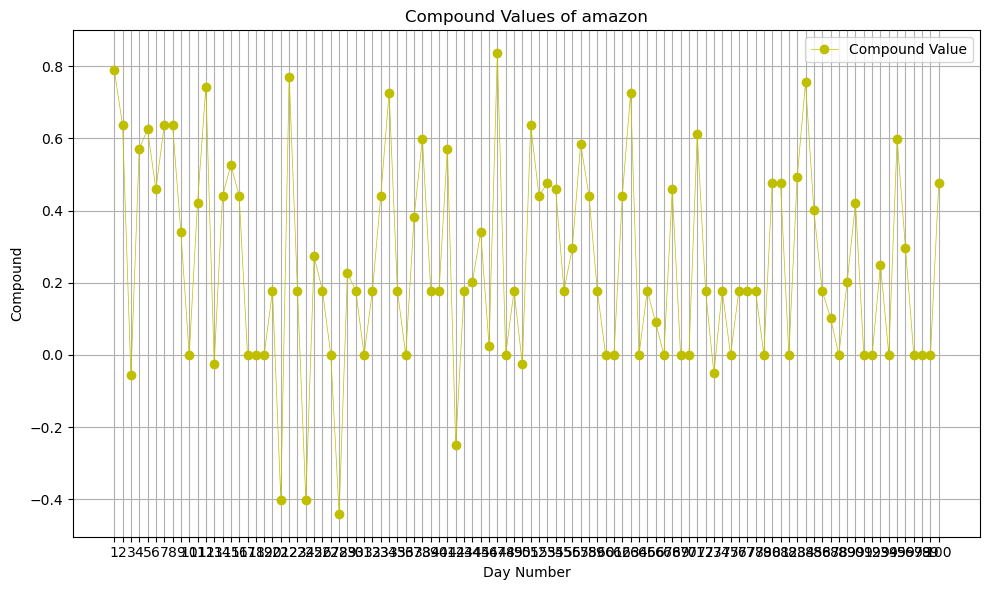

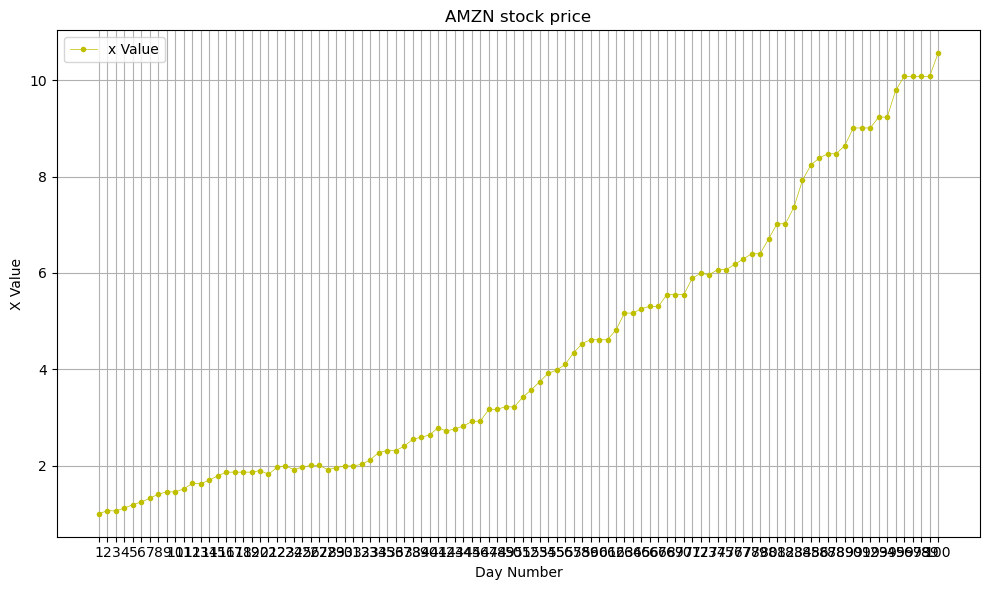

In [34]:
colors = []
for value in df3['compound']:
    if value > 0.5:
        colors.append('green')
    elif value < -0:
        colors.append('red')
    else:
        colors.append('yellow')

plt.figure(figsize=(10, 6))
plt.bar(df3.index + 1, df3['compound'], color=colors, width=0.8) 

plt.title('Compound Values Of Amazon')
plt.xlabel('Day')
plt.ylabel('Compound')
plt.axhline(0, color='black', linewidth=0.5)  
plt.xticks(df3.index + 1, [f'Day {i+1}' for i in df3.index], rotation=45)  
plt.tight_layout()

plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df3.index + 1, df3['compound'], marker='o', linestyle='-', color='y', linewidth=0.5, label='Compound Value')

plt.title('Compound Values of amazon')
plt.xlabel('Day Number')
plt.ylabel('Compound')
plt.xticks(df3.index + 1)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df3.index + 1, df3['x'], marker='.', linestyle='-', color='y', linewidth=0.5, label='x Value')

plt.title(f'{ticker} stock price')
plt.xlabel('Day Number')
plt.ylabel('X Value')
plt.xticks(df3.index + 1)  
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

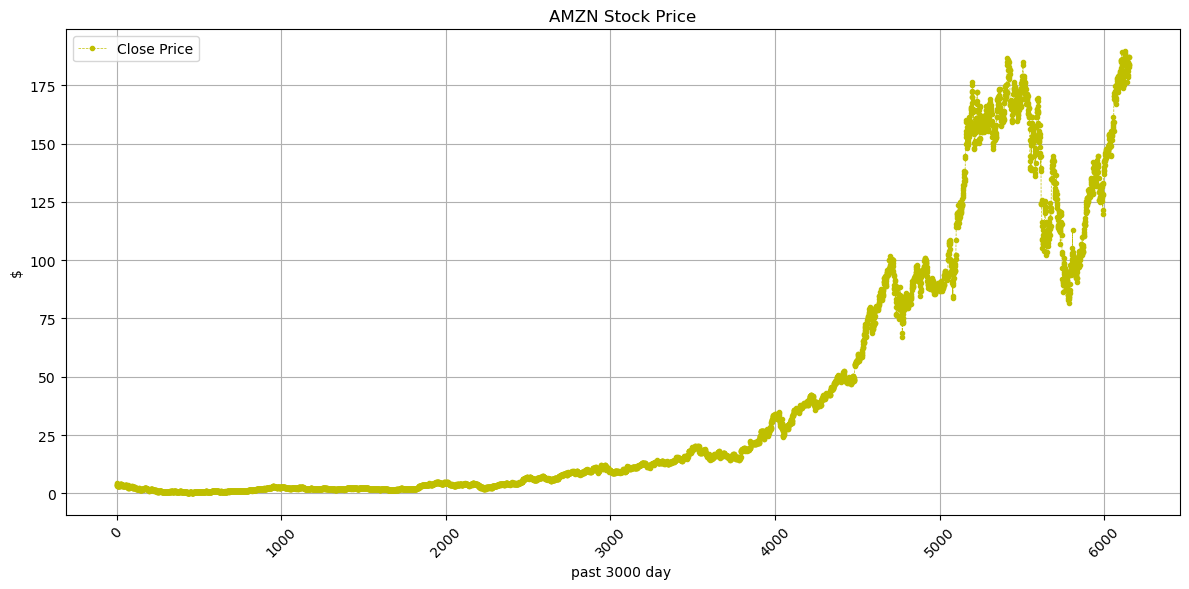

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data3.index, stock_data3['Close'], marker='.', linestyle='--', linewidth=0.5,color='y', label='Close Price')

plt.title(f'{ticker} Stock Price')
plt.xlabel('past 3000 day ')
plt.ylabel('$')
plt.xticks(rotation=45)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

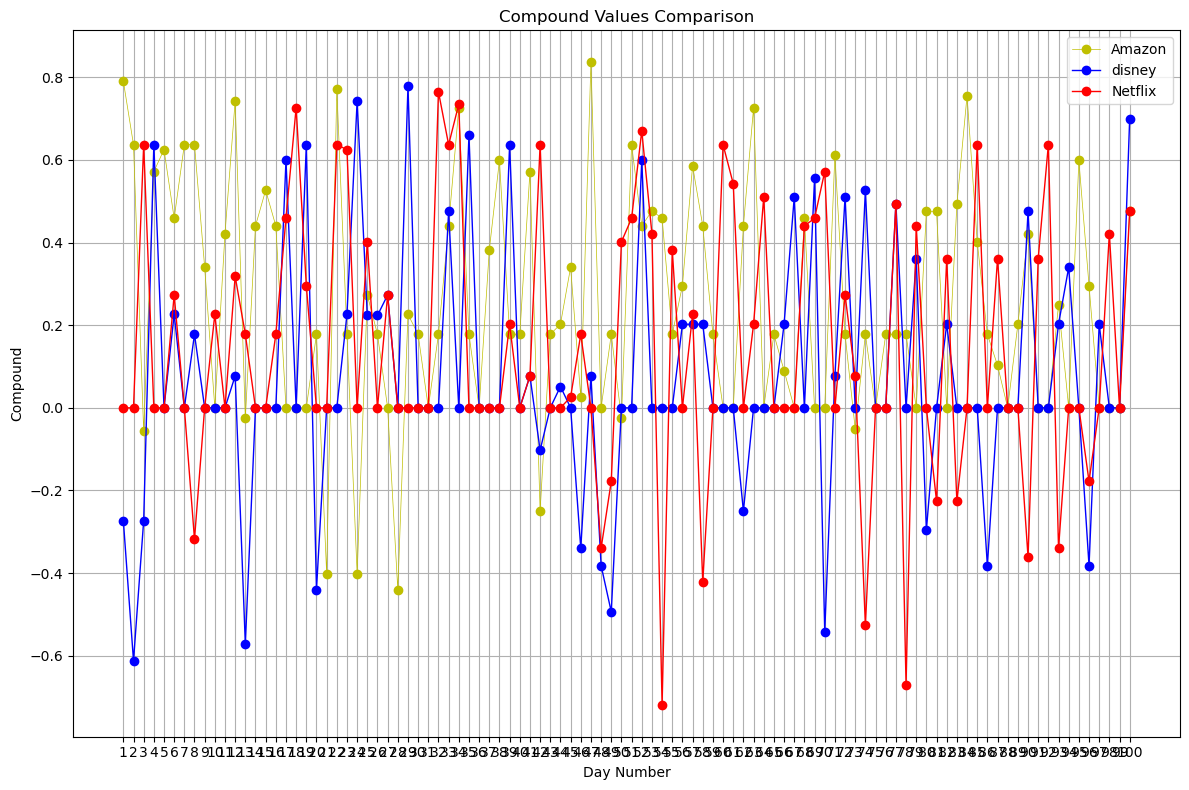

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.plot(df3.index + 1, df3['compound'], marker='o', linestyle='-', color='y', linewidth=0.5, label='Amazon')

plt.plot(df2.index + 1, df2['compound'], marker='o', linestyle='-', color='b', linewidth=1, label='disney')

plt.plot(df.index + 1, df['compound'], marker='o', linestyle='-', color='r', linewidth=1, label='Netflix')

plt.title('Compound Values Comparison')
plt.xlabel('Day Number')
plt.ylabel('Compound')

combined_ticks = list(set(df3.index + 1).union(set(df2.index + 1)).union(set(df.index + 1)))
plt.xticks(sorted(combined_ticks))

plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()
